In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

!nvidia-smi
#aqui reviso si hay gpu disponible 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Tue Jul  6 16:57:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.keras.datasets import cifar10
#se descarga cifar10 desde keras por que es mas facil editarla para los fines de la tarea.
(tmp, train_labels), (tmp2, test_labels) = cifar10.load_data()
#se normalizan las imagenes 
tmp=tmp.astype("float")/255.0
tmp2=tmp2.astype("float")/255.0

170500096/170498071 [==============================] - 3s 0us/step


In [3]:
from skimage.transform import resize
from skimage.filters import gaussian
print(tmp.shape)
#Se reestructuran las imagenes para que se puedan alimentar a la red segun el formato de tensorflow
train_images=np.transpose(tmp,(0,3,2,1))

#se reescalan las imagenes con las que se alimentará la red
temp=resize(train_images,(50000,3,16,16))
#$se aplica el filtro gaussiano
#sigma arbitrario de filtro gaussiano, se experimento con varios y este fue el que dio el mejor resultado al momento de hacer el training
sigma=0.3
y=gaussian(temp,sigma=(sigma,sigma,sigma),truncate=3.5,multichannel=True)
#se realiza el mismo proceso a las imagenes de prueba, con la diferencia que no se les aplica el filtro gaussiano
test_images=np.transpose(tmp2,(0,3,2,1))
print(test_images.shape)
yt=resize(test_images,(10000,3,16,16))

(50000, 32, 32, 3)
(10000, 3, 32, 32)


In [4]:
#structura que se utiliza para generar un trainloader para cualquier dataset
class oversampdata(Dataset):
  def __init__(self, datax,datay):
        self.data = torch.FloatTensor(datay)
        self.data2 = torch.FloatTensor(datax)
  def __len__(self):
      return len(self.data)
  def __getitem__(self, index):
        target = self.data2[index]
        data_val = self.data[index]
        return data_val,target

#se genera el trainloader para los conjuntos de prueba y entrenamiento que se generarion en la parte anterior
train_loader=torch.utils.data.DataLoader(oversampdata(train_images,y),batch_size=64,shuffle=True,num_workers=2)
test_loader=torch.utils.data.DataLoader(oversampdata(test_images,yt),batch_size=64,shuffle=True,num_workers=2)

Input images

(3, 146, 146)


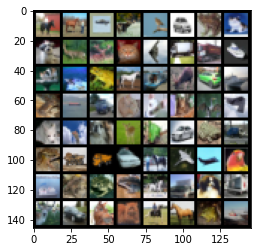

Output images

(3, 274, 274)


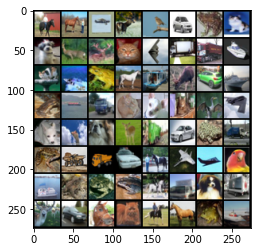

In [5]:
#pequeño bloque en el que se grafican algunas de las imagenes. en su version original y reducida
def imshow(img):
  npimg=img.numpy()
  #npimg=npimg/2+0.5
  print(npimg.shape)
  plt.imshow(np.transpose(npimg, (2, 1, 0)))
  plt.show()

dataiter=iter(test_loader)
images,labels=dataiter.next()
print("Input images\n")
imshow(torchvision.utils.make_grid(images))
print("Output images\n")
imshow(torchvision.utils.make_grid(labels))

In [6]:
#aqui es donde se declara la unet
#en esta implementacion la unet consiste en 3 bloques de condificacion, 3 de decodificacion y uno de salida o tail
#en cada bloque se reduce a la mitad el tamaño de las caracteristicas, por esta razon es necesario que la imagen que se alimente
#tenga una resolucion que sea divisible entre 8 
import torch.nn as nn
import torch.nn.functional as F
class Unet(nn.Module):
  def __init__(self):
    super(Unet,self).__init__()
    self.e_drop=nn.Dropout(p=0.25)
    self.e_pool=nn.MaxPool2d(1,2)
    #Encoder
    #blq1
    self.e_conv1=nn.Conv2d(3,32,3,padding=1)
    self.e_conv2=nn.Conv2d(32,32,3,padding=1)
    #blq2
    self.e_conv3=nn.Conv2d(32,64,3,padding=1)
    self.e_conv4=nn.Conv2d(64,64,3,padding=1)
    #blq3
    self.e_conv5=nn.Conv2d(64,128,3,padding=1)
    self.e_conv6=nn.Conv2d(128,128,3,padding=1)

    #decoder
    #blq4
    self.d_upsample1=nn.UpsamplingBilinear2d(scale_factor=2)
    self.d_conv1=nn.Conv2d(192,64,3,padding=1)
    self.d_conv2=nn.Conv2d(64,64,3,padding=1)
    #blq5
    self.d_conv3=nn.Conv2d(96,32,3,padding=1)
    self.d_conv4=nn.Conv2d(32,32,3,padding=1)
    #blq6
    self.d_conv5=nn.Conv2d(35,32,3,padding=1)
    self.d_conv6=nn.Conv2d(32,32,3,padding=1)
    #tail
    #blq7
    self.tail_conv1=nn.Conv2d(32,3,3,padding=1)
    self.tail_conv2=nn.Conv2d(3,3,1)
  
  
  
  #aqui se declara el forward que es la operacion que realizara la red.
  def forward(self,x):
    #bloque 1
    #comienza el encoder
    x=self.d_upsample1(x)
    x1=self.e_pool(self.e_drop(F.relu(self.e_conv2(F.relu(self.e_conv1(x))))))
    #bloque 2
    x2=self.e_pool(self.e_drop(F.relu(self.e_conv4(F.relu(self.e_conv3(x1))))))
    #bloque 3
    x3=(self.e_drop(F.relu(self.e_conv6(F.relu(self.e_conv5(x2))))))
    #bloque 4
    #empieza el decoder
    #bloque 
    
    xt=torch.cat([x3,x2],dim=1)
    x4=F.relu(self.d_conv1(xt))
    x4=F.relu(self.d_conv2(x4))
    x4=self.d_upsample1(self.e_drop(x4))
    #bloque 6
    xt=torch.cat([x4,x1],dim=1)
    x5=F.relu(self.d_conv3(xt))
    x5=F.relu(self.d_conv4(x5))
    x5=self.d_upsample1(self.e_drop(x5))
    #bloque 7
    x6=(self.e_drop(F.relu(self.d_conv6(F.relu(self.d_conv5(torch.cat([x5,x],dim=1)))))))
    #termina el decode
    #empieza la colitasion
    xf=self.tail_conv1(x6)
    xf=(self.tail_conv2(xf))
    xf=torch.sigmoid(xf)
    return xf
#se crea la red y se envia al dispositivo disponible, ya sea CPU o GPU
net=Unet()
net.to(device)

Unet(
  (e_drop): Dropout(p=0.25, inplace=False)
  (e_pool): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_upsample1): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (d_conv1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_conv3): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [7]:
#aqui se declara el optimizador a emplear durante el entrenamiento y la funcion de perdida
#Se opto por utilizar el RMS prop como optimizador y la perdidad L1 como criterio de perdida.
import torch.optim as optim
alpha=1e-5
decay=1e-4
optimizer = optim.RMSprop(net.parameters(),lr = 0.001,alpha = 0.9,eps = 1e-7)
criterion=nn.L1Loss()

In [8]:
import time
tic =time.time()
for epoch in range(20):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
      #se obtienen los datos del imput y se envian al dispositivo disponible
      inputs, labels = data
      inputs,labels=inputs.to(device),labels.to(device)
      # Se inicializa en cero el gradiente
      optimizer.zero_grad()

      #se realiza el forward, el backward y la optimzacion
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      #se imprime un poco de informacion relevante durante el entrenamiento 
      running_loss += loss.item()
      if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.5e' %
                  (epoch + 1, i + 1, running_loss / (100*64)))
            running_loss = 0.0

print('Finished Training, required %e seconds'%(time.time()-tic))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   100] loss: 2.23199e-03
[1,   200] loss: 1.49998e-03
[1,   300] loss: 1.28639e-03
[1,   400] loss: 1.16735e-03
[1,   500] loss: 1.10044e-03
[1,   600] loss: 1.03907e-03
[1,   700] loss: 9.93239e-04
[2,   100] loss: 9.31224e-04
[2,   200] loss: 9.03088e-04
[2,   300] loss: 8.59754e-04
[2,   400] loss: 8.40227e-04
[2,   500] loss: 8.22104e-04
[2,   600] loss: 8.05411e-04
[2,   700] loss: 7.91520e-04
[3,   100] loss: 7.72097e-04
[3,   200] loss: 7.61662e-04
[3,   300] loss: 7.52259e-04
[3,   400] loss: 7.41246e-04
[3,   500] loss: 7.33796e-04
[3,   600] loss: 7.29829e-04
[3,   700] loss: 7.18333e-04
[4,   100] loss: 7.05949e-04
[4,   200] loss: 7.02041e-04
[4,   300] loss: 6.93153e-04
[4,   400] loss: 6.93974e-04
[4,   500] loss: 6.81903e-04
[4,   600] loss: 6.83639e-04
[4,   700] loss: 6.80105e-04
[5,   100] loss: 6.69824e-04
[5,   200] loss: 6.65045e-04
[5,   300] loss: 6.63082e-04
[5,   400] loss: 6.65210e-04
[5,   500] loss: 6.56138e-04
[5,   600] loss: 6.54906e-04
[5,   700] los

KeyboardInterrupt: ignored

In [ ]:
#save model
PATH = './unet.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
#Aqui se realiza la prueba con las disintas imagenes
correct = 0
total = 0
it=iter(train_loader)
with torch.no_grad():
    for i in range(2):
        images, labels = it.next()
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        print("Imagenes extendidas\n")
        imshow(torchvision.utils.make_grid(outputs.cpu()));
        print("Imagenes de prueba\n")
        imshow(torchvision.utils.make_grid(labels.cpu()));

In [ ]:
#Aqui se imrpimen algunas ejemplos de los resultados obtenidos en tamaño mas grande
outputs=outputs.cpu()
labels=labels.cpu()
print("Imagene extendida\n")
imshow(outputs[5]);
print("Imagen de prueba\n")
imshow(labels[5])
